# make numpy array for training

In [1]:
import time
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable

In [2]:
f_rnd = pd.read_hdf("/data/t3home000/spark/LHCOlympics_previous/LHC-Olympics/Code/Nsubjettiness_mjj.h5")

In [3]:
dt = f_rnd.values

In [4]:
index_list = [0,1,2,3,4,5,7,8,9,10,11,12]
for i in index_list:
    dt[:,i] = (dt[:,i]-np.mean(dt[:,i]))/np.std(dt[:,i])

In [5]:
idx = dt[:,15]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

In [6]:
X = dt[:,[0,1,2,3,4,5,7,8,9,10,11,12]]

In [7]:
X.shape

(1100000, 12)

In [8]:
y = idx

In [9]:
y.shape

(1100000,)

# Normalize Inputs

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(
#    X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42)

In [12]:
print(X_train.shape, X_val.shape, X_test.shape)

(880000, 12) (110000, 12) (110000, 12)


In [13]:
class trainData(utils.Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



## test data    
class testData(utils.Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    



In [14]:
train_data = trainData(torch.FloatTensor(X_train.astype(np.float)),torch.FloatTensor(y_train.astype(np.float)))
val_data = trainData(torch.FloatTensor(X_val.astype(np.float)),torch.FloatTensor(y_val.astype(np.float)))
test_data = testData(torch.FloatTensor(X_test.astype(np.float))) 

# Make Dataloader

In [15]:
import torch

In [16]:
torch.cuda.is_available()

True

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'GeForce RTX 2080 Ti'

In [18]:
BATCH_SIZE = 1000
N_EPOCHS = 80
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

# NN classifier

In [19]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(12,84)
        self.linear2 = nn.Linear(84,42)
        self.linear3 = nn.Linear(42,21)
        self.linear4 = nn.Linear(21,10)
        self.linear5 = nn.Linear(10,5)
        self.linear_out = nn.Linear(5,1)
        
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(84)
        self.batchnorm2 = nn.BatchNorm1d(42)
        self.batchnorm3 = nn.BatchNorm1d(21)
        self.batchnorm4 = nn.BatchNorm1d(10)
        self.batchnorm5 = nn.BatchNorm1d(5)
        

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.batchnorm1(self.linear1(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm2(self.linear2(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm3(self.linear3(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm4(self.linear4(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm5(self.linear5(x))
        x = F.leaky_relu(x)
        x = self.linear_out(x)
        return x





In [20]:
model = Net()

print(model)
model.to(device)

Net(
  (linear1): Linear(in_features=12, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=42, bias=True)
  (linear3): Linear(in_features=42, out_features=21, bias=True)
  (linear4): Linear(in_features=21, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=5, bias=True)
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Net(
  (linear1): Linear(in_features=12, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=42, bias=True)
  (linear3): Linear(in_features=42, out_features=21, bias=True)
  (linear4): Linear(in_features=21, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=5, bias=True)
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [21]:
# optimizer
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

In [22]:
device

device(type='cuda', index=0)

In [33]:
train_loader = utils.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = utils.DataLoader(dataset=val_data, batch_size=100)
test_loader = utils.DataLoader(dataset=test_data, batch_size=100)

In [24]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [25]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    epoch_loss = 0
    epoch_acc = 0

    for x, y in train_loader:
        # reshape the data into [batch_size, 784]
        x,y = x.to(device), y.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        y_pred = model(x)

        # reconstruction loss
        #recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

        # kl divergence loss
        #kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        #loss = recon_loss + kl_loss

        #BCE loss
        loss = criterion(y_pred, y.unsqueeze(1))
        acc = binary_acc(y_pred, y.unsqueeze(1))
        
        # backward pass
        loss.backward()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # update the weights
        optimizer.step()

    return epoch_loss


In [26]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for x, y in val_loader:
            # reshape the data
            #x = x.view(-1, 28 * 28)
            x,y = x.to(device), y.to(device)
            # forward pass
            y_pred = model(x)

            loss = criterion(y_pred, y.unsqueeze(1))
            acc = binary_acc(y_pred, y.unsqueeze(1))
            # total loss
            
            test_loss += loss.item()

    return test_loss

In [29]:
best_test_loss = float('inf')

for e in range(100):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_data)
    test_loss /= len(val_data)

    print(f'Epoch {e}, Train Loss: {train_loss:.7f}, Test Loss: {test_loss:.7f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        print('patience limit reached')
        break

Epoch 0, Train Loss: 0.0000869, Test Loss: 0.0008187
Epoch 1, Train Loss: 0.0000867, Test Loss: 0.0008146
Epoch 2, Train Loss: 0.0000867, Test Loss: 0.0008152
Epoch 3, Train Loss: 0.0000866, Test Loss: 0.0008166
Epoch 4, Train Loss: 0.0000865, Test Loss: 0.0008143
Epoch 5, Train Loss: 0.0000865, Test Loss: 0.0008138
Epoch 6, Train Loss: 0.0000865, Test Loss: 0.0008129
Epoch 7, Train Loss: 0.0000863, Test Loss: 0.0008161
Epoch 8, Train Loss: 0.0000865, Test Loss: 0.0008113
Epoch 9, Train Loss: 0.0000862, Test Loss: 0.0008108
Epoch 10, Train Loss: 0.0000861, Test Loss: 0.0008131
Epoch 11, Train Loss: 0.0000861, Test Loss: 0.0008120
Epoch 12, Train Loss: 0.0000858, Test Loss: 0.0008118
patience limit reached


In [30]:
torch.save(model.state_dict(), "/data/t3home000/spark/QUASAR/weights/fully_connected_ref_12inputs.h5")

In [34]:
model.eval()
y_pred_list = np.array([],dtype=np.float)
with torch.no_grad():
    for batch_idx, X_batch in enumerate(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list = np.append(y_pred_list,y_test_pred.cpu().numpy())
        


In [47]:
truesig = np.where(y_test==1)
truebkg = np.where(y_test==0)
sigscore = y_pred_list[truesig]
bkgscore = y_pred_list[truebkg]

In [48]:
sigscore.shape

(10156,)

In [50]:
print(sigscore)

[0.53497952 0.84764886 0.99262577 ... 0.7674371  0.84466892 0.99842227]


In [70]:
bkgscore.shape

(99844,)

In [71]:
print(y_pred_list.shape,y_test.shape)
print(y_pred_list[:20],y_test[:20])

(110000,) (110000,)
[6.01285370e-03 1.40656037e-02 6.33050862e-04 9.06132385e-02
 4.29636799e-03 2.59291963e-04 2.91777588e-03 9.88843734e-04
 1.93072669e-03 2.13927981e-02 2.22644396e-03 3.17776599e-03
 7.99695496e-03 6.96382206e-03 3.63481743e-03 5.33045316e-03
 5.50930796e-04 1.47437686e-02 5.34979522e-01 2.88454480e-02] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [86]:
def get_tpr_fpr(sigloss,bkgloss):
    bins = np.linspace(0,1,100001)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    
    return tpr,fpr  

In [87]:
tpr, fpr = get_tpr_fpr(sigscore,bkgscore)

In [89]:
np.save('supervised_ref_tpr.npy',tpr)
np.save('supervised_ref_fpr.npy',fpr)

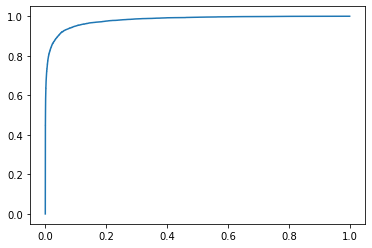

In [88]:
plt.plot(fpr,tpr)

In [77]:
max(0,1e-6)

1e-06

In [91]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,1,100001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            if (np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]) != 0:
                tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
                precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [92]:
precision, recall = get_precision_recall(sigscore,bkgscore)

In [94]:
np.save('supervised_ref_precision.npy',precision)
np.save('supervised_ref_recall.npy',recall)

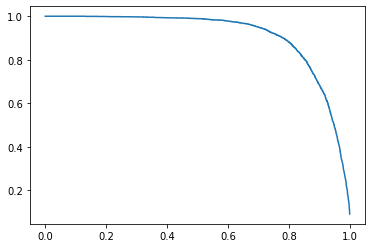

In [95]:
plt.plot(recall,precision)

# Now time to train a simple NN

In [ ]:
plt.hist(data_branches[b'vjet0_msd0'][y_pred_list>-40],1000)

In [ ]:
data

In [ ]:
f = uproot.update("data/JetHT_s.root")

In [ ]:
data   = uproot.open("data/JetHT_s.root")["Tree"]
data.extend({"NN_score":y_pred_list})

In [ ]:
import numpy as np

In [ ]:
N, D_in, H, D_out = 64, 1000, 100, 10

In [ ]:
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

In [ ]:
print(x.shape)

In [ ]:
# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

In [ ]:
learning_rate = 1e-6

In [ ]:
for i in range(500):
    #forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h,0)
    y_pred = h_relu.dot(w2)
    
    loss = np.square(y_pred-y).sum()
    print(t,loss)
    
    # back propagation
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2  = h_relu.T.dot(grad_y_pred)
    g
    
    
    